In [ ]:
# default_exp searcher

# Searcher

> Searchers are a one of the main block of web2dataset. They define the code to scrap the web for images

In [ ]:
# hide
from nbdev.showdoc import *

here is the abstract class for the Searcher 

In [ ]:
# export
import os
from typing import List
from web2dataset.document import Document

import json
import jsons

In [ ]:
# exports
class Searcher:
    def __init__(self, query: str, n_item: int):
        self.query = query
        self.n_item = n_item
        self.documents: List[Document] = []

    def search(self):
        pass
    
    def save(self,path: str):
        """
        path: folder path
        """
        
        if not os.path.isdir(path):
            os.mkdir(path)
        
        os.chdir(path)
        
        for doc in self.documents:
            with open(f"{doc.uuid}.json", 'w') as fp:
                
                json.dump(jsons.dump(doc),fp)
        

Example: simple searcher:

In [ ]:
class BasicSearcher(Searcher):
    def search(self):
        self.documents.append(Document(origin="https://www.google.fr"))

let's define a searcher that will search random wallpaper on the web

In [ ]:
searcher = BasicSearcher("wallpaper", 1)
searcher.search()
assert len(searcher.documents) == searcher.n_item

we can then save the documents by giving a folder path to the method save_docs_to_file

In [ ]:
searcher.save("/tmp/my_search")

let's define the core error as well

In [ ]:
# export

class SearchError(ValueError):
    pass

# Google image searcher

> The Google searcher is the first and main searcher

In [ ]:
# export
from contextlib import contextmanager

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.webdriver import WebDriver
from selenium.webdriver.common.by import By
from selenium.webdriver.remote.webelement import WebElement

first lets design a simple context manager to open and close the web driver automatically

In [ ]:
# export
@contextmanager
def _get_driver(debug=False):

    if debug:
        driver = webdriver.Chrome()
    else:
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        driver = webdriver.Chrome(options=chrome_options)
    try:
        yield driver
    finally:
        driver.quit()

In [ ]:
with _get_driver() as driver:
    pass

Then the google image searcher

In [ ]:
# export 
class GoogleImageSearchError(SearchError):
    pass

In [ ]:
# export
class GoogleImageSearcher(Searcher):
    """
    query: str, it contains the query that is send to google search
    """
    def __init__(self, query: str, n_item: int):
        super().__init__(query, n_item)
        
        self.google_image_url = self._create_url_from_query(self.query)

        
    def _create_url_from_query(self, query: str) -> str:
        if "+" in query:
            raise GoogleImageSearchError(" + should not be in the query because the whitespace are replaced by + so the meaning is different")
        return f"https://www.google.com/search?q={query.replace(' ','+')}&source=lnms&tbm=isch"
    
    def _element_to_document(self, element):
        url = element.get_attribute("src")
        return Document(origin=self.query, image_url=url)

    def _find_images(self, driver: WebDriver) -> List[WebElement]:
        return driver.find_elements(By.CLASS_NAME, "rg_i")

    def _scrap_all_images_in_current_page(self, driver: WebDriver):
        elements = self._find_images(driver)
        self.elements = elements
        self.documents += [
            self._element_to_document(e)
            for i, e in enumerate(elements)
            if len(self.documents) + i < self.n_item
        ]

    def _scroll_to_next_page(self, driver: WebDriver):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    def search(self):
        with _get_driver() as driver:

            driver.get(self.google_image_url)

            _continue = True
            while _continue:
                self._scrap_all_images_in_current_page(driver)
                _continue = len(self.documents) < self.n_item

                if _continue:
                    self._scroll_to_next_page(driver)

In [ ]:
ggl_searcher = GoogleImageSearcher(
    "race bike",    
    100,
)

In [ ]:
%%time
ggl_searcher.search()

CPU times: user 110 ms, sys: 4.08 ms, total: 114 ms
Wall time: 3.41 s


In [ ]:
assert len(ggl_searcher.documents) == ggl_searcher.n_item

In [ ]:
url = [doc.image_url for doc in ggl_searcher.documents]
len(url), len(set(url))

(100, 41)

In [ ]:
docs = { doc.image_url:doc for doc in ggl_searcher.documents}


[{"date": "2021-12-02T10:24:23.182968+01:00", "image_url": "", "origin": "race bike", "uuid": "a2e229aa-5351-11ec-87d9-645d865124e9"},
 {"date": "2021-12-02T10:24:23.190486+01:00", "image_url": "", "origin": "race bike", "uuid": "a2e34f38-5351-11ec-87d9-645d865124e9"},
 {"date": "2021-12-02T10:24:23.199029+01:00", "image_url": "", "origin": "race bike", "uuid": "a2e49cee-5351-11ec-87d9-645d865124e9"},
 {"date": "2021-12-02T10:24:23.206472+01:00", "image_url": "", "origin": "race bike", "uuid": "a2e5bff2-5351-11ec-87d9-645d865124e9"},
 {"date": "2021-12-02T10:24:23.214946+01:00", "image_url": "", "origin": "race bike", "uuid": "a2e70baa-5351-11ec-87d9-645d865124e9"},
 {"date": "2021-12-02T10:24:23.222672+01:00", "image_url": "", "origin": "race bike", "uuid": "a2e8389a-5351-11ec-87d9-645d865124e9"},
 {"date": "2021-12-02T10:24:23.229780+01:00", "image_url": "", "origin": "race bike", "uuid": "a2e94f28-5351-11ec-87d9-645d865124e9"},
 {"date": "2021-12-02T10:24:23.238727+01:00", "image_ur
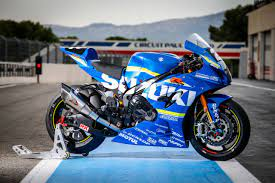
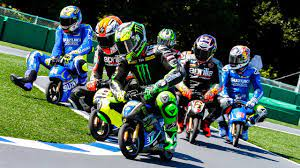
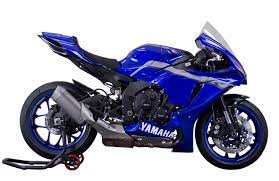
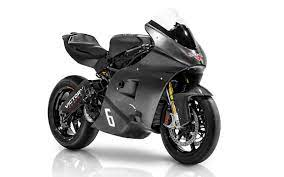
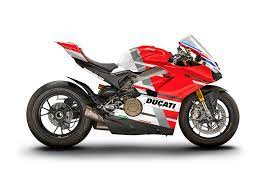
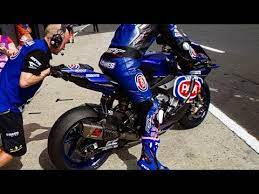
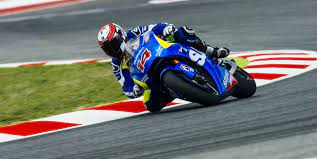
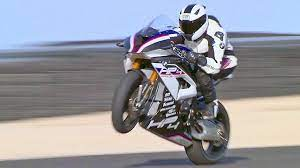
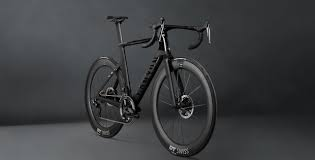
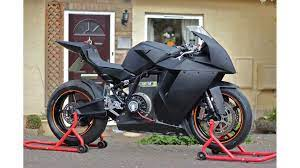
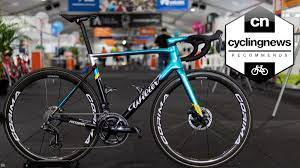
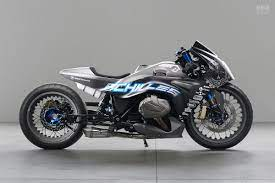
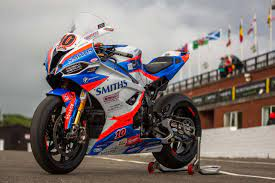
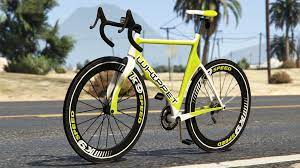
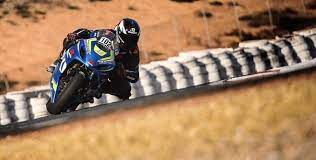
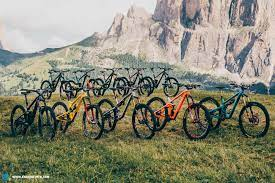
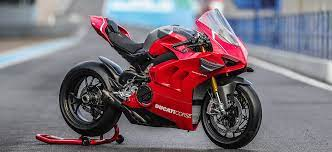
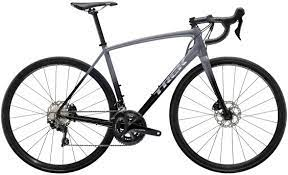
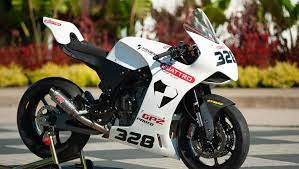
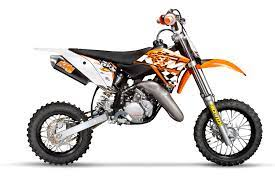

In [ ]:
list(docs.values())